In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cloud_func_lib as cfl
import xarray as xr

In [10]:
cf_paths = '/home/users/eers/sct/lwp_mask_csvs/sct_{}{}_cloud_frac.csv'
times_paths = '/home/users/eers/sct/lwp_mask_csvs/sct_{}{}_times.csv'

In [11]:
def load_cf(design, number):
    cf = np.loadtxt(cf_paths.format(design, number), delimiter=',')
    times = np.loadtxt(times_paths.format(design, number), delimiter=',')
    return cf, times

def load_cf_design(design, design_size):
    #design_cf = np.zeros((design_size, 60))
    #design_times = np.zeros((design_size, 60))
    cf_dict = {}
    for number in range(design_size):
        number_cf, number_times = load_cf(design, number)
        cf_dict[f'{design}{number}'] = [number_cf[1:], number_times[1:]]  # ignore spin up period
    return cf_dict

def sorter(key, simulation, times):
    # Does the simulation form Sc?
    if any(cf > 0.9 for cf in simulation):
        # Which indices have Sc?
        sc, = np.where(simulation > 0.9)   # simulation[1:] not including spin up
        sc_time = times[sc[0]]
        # Out of those indices, which following ones have Cu?
        cu, = np.where(simulation[sc[0]:] < 0.55)
        # cu_ind refers to the original simulation indices that have Cu
        cu_ind = cu + sc[0]
        
        # Does Cu form and the simulation finishes in a Cu state?
        if len(cu)!=0 and simulation[-1]<0.55:
            
            # Does it stay in Cu from the initial Cu formation?
            if all(simulation[cu_ind[0]:] < 0.55):
                output_value = times[cu_ind[0]] - times[sc[0]]
                output_time = times[cu_ind[0]]
                
            # For the case where it recovers from Cu but will eventually return to Cu
            else:
                # Find the difference between the indices that have Cu, take the index which is the last one with a difference of more than one timestep. 
                # From this point, the differences are only one timestep so the cloud does not recover again.
                diff = cu[1:] - cu[:-1]
                i, = np.where(diff > 1)
                output_value = times[cu_ind[i[-1]+1]] - times[sc[0]]
                output_time = times[cu_ind[i[-1]+1]]
        # Where no Cu is formed or it forms but then recovers - could split this for ones that form Cu 
        else:
            output_value = 80
            output_time = output_value
    # Where no Sc is formed
    else:
        output_value = -1
        output_time = output_value
        sc_time = -1
    return output_value, output_time, sc_time
        

In [12]:
em_cf_dict = load_cf_design('em', 61)
val_cf_dict = load_cf_design('val', 24)
#total_design_cf = np.concatenate((em_design_cf, val_design_cf), axis=0)
#total_design_times = np.concatenate((em_design_times, val_design_times), axis=0)
#total_design_cf[total_design_cf==0] = np.nan
em_cf_dict.update(val_cf_dict)

In [13]:
transition_times = []
for i, (key, val) in enumerate(em_cf_dict.items()):
    output_value, output_time, sc_time = sorter(key, val[0], val[1])
    em_cf_dict[key].append(output_value)
    transition_times.append(output_value)
    em_cf_dict[key].append(output_time)
    em_cf_dict[key].append(sc_time)

In [6]:
np.savetxt("/home/users/eers/sct/output_data/sct_all_confirmed_transition_times.csv", transition_times, delimiter=',')

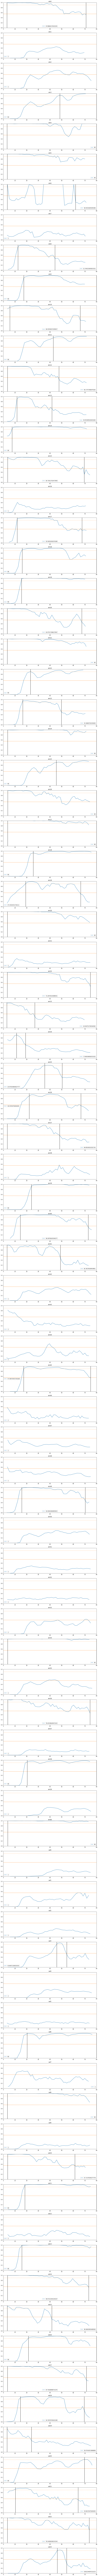

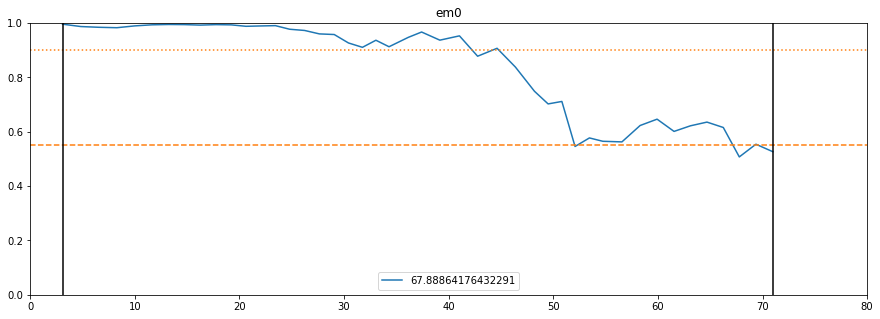

In [6]:
fig,ax = plt.subplots(nrows=85, ncols=1, figsize=(15,85*5))
for i, (key, val) in enumerate(em_cf_dict.items()):
    ax[i].plot(val[1], val[0], label=val[2])
    ax[i].plot((0,80),(0.9,0.9), ':', c='C1')
    ax[i].plot((0,80),(0.55,0.55), '--', c='C1')
    ax[i].plot((val[3], val[3]), (0,1), c='black')
    ax[i].plot((val[4], val[4]), (0,1), c='black')
    ax[i].legend()
    ax[i].set_ylim((0,1))
    ax[i].set_xlim((0,80))
    ax[i].set_title(key)
    
    if i==0:
        save=True
    else:
        save=False
    
    if save:
        fig2, ax2 = plt.subplots(figsize=(15,5))
        ax2.plot(val[1], val[0], label=val[2])
        ax2.plot((0,80),(0.9,0.9), ':', c='C1')
        ax2.plot((0,80),(0.55,0.55), '--', c='C1')
        ax2.plot((val[3], val[3]), (0,1), c='black')
        ax2.plot((val[4], val[4]), (0,1), c='black')
        ax2.legend()
        ax2.set_ylim((0,1))
        ax2.set_xlim((0,80))
        ax2.set_title(key)
        fig2.savefig(f"/home/users/eers/sct/analysis_plots/cf_check_{key}.png")

In [14]:
surface_boundary_input_times = [0.0, 28800.0, 50400.0, 72000.0, 93600.0,117000.0,136800.0,158400.0,180000.0,201600.0,223200.0,243800.0,266400.0]
surface_temperatures  = [293.75, 294.16, 294.55, 295.08, 295.57, 296.1, 296.55, 297.02, 297.54, 298.06, 298.44, 298.8, 299.17]

In [15]:
def find_sst(model_time, sst_input_times, ssts):
    previous_input_times = [i for i, input_time in enumerate(sst_input_times) if model_time > input_time/3600]
    if len(previous_input_times)!=0:
        current_sst = ssts[previous_input_times[-1]]
    else:
        current_sst = -1
    return current_sst

In [16]:
sst_initials = []
sst_transitions = []
for i, (key, val) in enumerate(em_cf_dict.items()):
    sst_initials.append(find_sst(em_cf_dict[key][4], surface_boundary_input_times, surface_temperatures))
    sst_transitions.append(find_sst(em_cf_dict[key][3], surface_boundary_input_times, surface_temperatures))

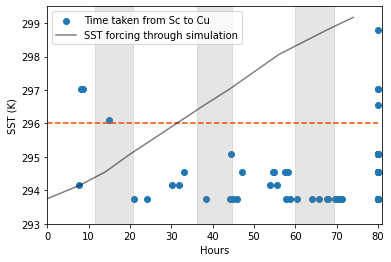

In [28]:
sst_initials_array = np.asarray(sst_initials)
transition_times_array = np.asarray(transition_times)
sst_valid = sst_initials_array[sst_initials_array>0]
transition_times_valid = transition_times_array[sst_initials_array>0]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(transition_times_valid,sst_valid, label='Time taken from Sc to Cu')
ax.plot((0,80), (296,296), c='orangered', linestyle='--')
ax.plot([t/3600 for t in surface_boundary_input_times], surface_temperatures, alpha=0.5, c='black', label="SST forcing through simulation")
ds = xr.open_dataset("/gws/nopw/j04/carisma/eers/sct/em/em0/sct_em0_merged.nc")
ds = cfl.ds_fix_dims(ds)
cfl.add_diurnal(ds, ax, (292,300))
ax.set_ylim((293,299.5))
ax.set_xlim((0,81))
ax.set_xlabel("Hours")
ax.set_ylabel("SST (K)")
ax.legend()
fig.savefig("/home/users/eers/sct/analysis_plots/transition_vs_sst.png")

In [43]:
a,=np.where(sst_initials_array>296)
print(a)

[ 3 10 24 34 63 80 83]


In [31]:
### make SST colourmap
norm = colors.Normalize(vmin=surface_temperatures[0], vmax=surface_temperatures[-1])
cmap = plt.cm.autumn_r

In [41]:
np.savetxt("/home/users/eers/sct/output_data/sct_all_sst_at_initial_sc.csv", sst_initials, delimiter=',')

In [19]:
if 'em6' in em_cf_dict.keys():
    del em_cf_dict['em6'] # delete 6 because it's crazy, also em_cf_dict is actually the whole thing - updated above
    if len(sst_initials_array)==85:
        sst_initials_array = np.delete(sst_initials_array, 6)
    
# add sc index
for key, val in em_cf_dict.items():
    if val[4]!=-1:
        sc_ind = np.argmin(np.abs(val[1] - val[4]))
        em_cf_dict[key].append(sc_ind)
    else:
        em_cf_dict[key].append(-1)

In [12]:
em_cf_dict['em1'] # cf, times, time taken to transition, actual time stamp of transition, initial Sc time

[array([0.        , 0.        , 0.        , 0.        , 0.02919006,
        0.22119141, 0.27470398, 0.26925659, 0.26452637, 0.24226379,
        0.22984314, 0.24356079, 0.27218628, 0.32905579, 0.36108398,
        0.39332581, 0.39758301, 0.39865112, 0.41081238, 0.42807007,
        0.45077515, 0.43505859, 0.42024231, 0.36244202, 0.30725098,
        0.27738953, 0.25839233, 0.21505737, 0.22138977, 0.23434448,
        0.25689697, 0.25018311, 0.21144104, 0.21502686, 0.18791199,
        0.19914246, 0.2207489 ]),
 array([ 5.83144857,  8.74811523, 11.6647819 , 14.58144857, 17.47915473,
        20.06364149, 22.22717665, 24.19131293, 25.96541667, 27.62991319,
        29.15638238, 30.55707899, 31.81860243, 34.00858941, 35.87570964,
        37.59736111, 39.22741319, 40.77551215, 42.30885851, 43.83140625,
        45.33202691, 46.79170139, 48.26384983, 49.76801649, 51.27505208,
        52.78328125, 54.28714844, 55.76062934, 57.21871962, 58.61586372,
        59.96557726, 61.28832899, 62.59299913, 63.87

In [80]:
def calc_mean_timestep_values(cf_dict, v_ind, simple_action, condition):
    mean_list = []
    for i in range(60):
        timestep_values = [simple_action(val, v_ind, i) for key, val in cf_dict.items() if condition(val, v_ind, i)]
        if len(timestep_values)!=0:
            mean_list.append(np.nanmean(timestep_values))
        else:
            mean_list.append(np.nan)
    return mean_list

def plot_means(ax, cf_dict, plot_all, t0, start_together, highlight, show_sc_start, simple_action, condition):  # all [T/F], t0 [T/F], highlight [empty/list]
    handles=[]
    for total_sim_number, (key, val) in enumerate(em_cf_dict.items()):         
        if t0:
            times = val[1]
            cf = val[0]
        else:
            times = val[1][val[5]:]
            cf = val[0][val[5]:]
            
        if key in highlight:
            c = "green"
            lw = 2
        else:
            c = 'C0'
            lw = 1
            
        alpha = 0.2
        outliers,=np.where(sst_initials_array>296)
        if start_together:
            times = times - times[0]
            show_sc_start = False  # no point showing sc start if starting together, just a catch
            #c = cmap(norm(sst_initials_array[total_sim_number]))
            if total_sim_number in outliers:
                c="orangered"
                lw = 2
                alpha = 1
            else:
                c="orange"
                lw = 1
                alpha = 0.3
            # could add patches here for the final plot if to label legend the lines if need be
            
        if plot_all:
            ax.plot(times, cf, alpha=alpha, c=c, lw=lw)
        else:
            if val[4]!=-1:
                ax.plot(times, cf, alpha=alpha, c=c, lw=lw)
                    
        if show_sc_start and val[4]!=-1:
            #ax.plot((val[4],val[4]), (0,1), color=cmap(norm(sst_initials_array[total_sim_number])), linestyle='--') #, alpha=0.3)
            if total_sim_number in outliers:
                reds,= ax.plot((val[4],val[4]), (0,1), color="orangered", linestyle='--', label='SST > 296K') #, alpha=0.3)
                if len(handles) < 2:
                    handles.append(reds)
            else:
                oranges,=ax.plot((val[4],val[4]), (0,1), color="orange", linestyle='--', label='SST < 296K') #, alpha=0.3)
                if len(handles) < 2:
                    handles.append(oranges)

    mean_cf = calc_mean_timestep_values(cf_dict, 0, simple_action, condition)
    mean_times = calc_mean_timestep_values(cf_dict, 1, simple_action, condition)
    
    if start_together:
        mean_times = [time - mean_times[1] for time in mean_times]
    
    mean_line, = ax.plot(mean_times, mean_cf, c='black', lw=2, label="Mean")
    handles.append(mean_line)
    ax.legend(handles=handles, loc='lower right')
    return ax

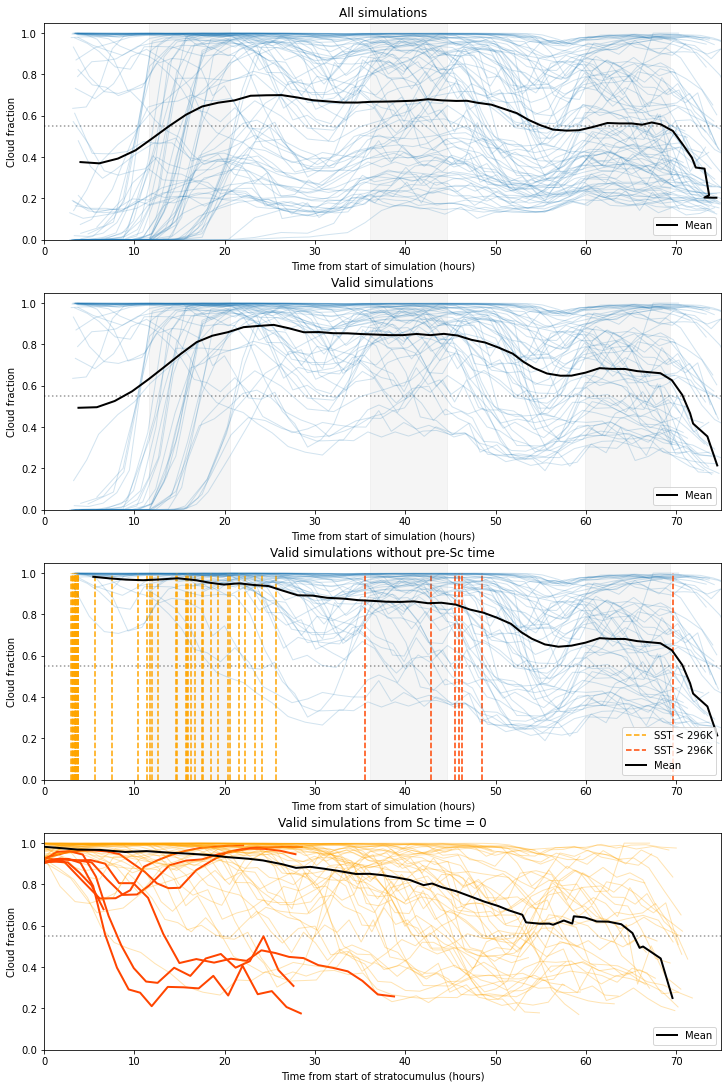

In [82]:
### Plotting all cloud fractions together
### Highlights are 'val3','val23'. Leaving them off now. They alerted me to the issue but it's gone beyond that now so other simulations are relevant too.
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,15), constrained_layout=True)

titles = ["All simulations", "Valid simulations", "Valid simulations without pre-Sc time", "Valid simulations from Sc time = 0"]
xlabels = ["simulation", "simulation", "simulation", "stratocumulus"]
ds = xr.open_dataset("/gws/nopw/j04/carisma/eers/sct/em/em0/sct_em0_merged.nc")
ds = cfl.ds_fix_dims(ds)
for a, title, x in zip(ax, titles, xlabels):
    a.set_title(title)
    a.set_ylabel("Cloud fraction")
    a.set_xlabel(f"Time from start of {x} (hours)")

    a.set_xlim((0,75))
    a.set_ylim((0,1.05))
    if x!='stratocumulus':
        cfl.add_diurnal(ds, a, (0,1.05), 0.08)
    a.plot((0, 75), (0.55, 0.55), linestyle=':', c='black', alpha=0.4)

plot_means(ax[0], em_cf_dict, True, True, False, [], False, lambda x, v_ind, i: x[v_ind][i],  
           lambda x, v_ind, i: len(x[v_ind])>i)
plot_means(ax[1], em_cf_dict, False, True, False, [], False, lambda x, v_ind, i: x[v_ind][i], 
           lambda x, v_ind, i: len(x[v_ind])>i and x[4]!=-1)
plot_means(ax[2], em_cf_dict, False, False, False, [], True, lambda x, v_ind, i: x[v_ind][i], 
           lambda x, v_ind, i: len(x[v_ind])>i and x[4]!=-1 and i > x[5])
plot_means(ax[3], em_cf_dict, False, False, True, [], True, lambda x, v_ind, i: x[v_ind][x[5]+i], 
           lambda x, v_ind, i: len(x[v_ind])>i+x[5] and x[4]!=-1 and i > x[5])

fig.savefig("/home/users/eers/sct/analysis_plots/all_cf_summary_sst_colours.png")